In [ ]:
# =============================================================
# Unified PIELM solver
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, Tuple
from scipy.stats.qmc import Halton
from matplotlib.path import Path
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
pi = np.pi

# ---------- activation & exact derivatives ----------
phi     = np.tanh
phi_p   = lambda z: 1.0 - np.tanh(z)**2
phi_pp  = lambda z: -2.0*np.tanh(z)*(1.0 - np.tanh(z)**2)

# ---------- helpers ----------
def _as_fun(v, nargs: int):
    """Return f(*xs) that yields array shape (N,1) from scalar/const/func."""
    if callable(v):
        return v
    else:
        if nargs == 1:
            return lambda x: np.full_like(x, float(v))
        if nargs == 2:
            return lambda x, y: np.full_like(x, float(v))
        if nargs == 3:
            return lambda x, y, t: np.full_like(x, float(v))

# ---------- plotting blocks ----------
def _plot1d_steady(u_pred, u_exact, xL, xR, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    up = u_pred(x).reshape(-1,1)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3.3), constrained_layout=True)
    if u_exact is not None:
        ue  = u_exact(x)
        ax0.plot(x, ue, 'b', lw=1.8, label='Exact')
        err = (up - ue)
    else:
        err = np.zeros_like(up)
    ax0.plot(x, up, 'r--', lw=1.8, label='PIELM')
    ax0.set_title(title or 'Solution')
    ax0.set_xlabel('x'); ax0.set_ylabel('u'); ax0.grid(alpha=.3); ax0.legend()
    ax1.plot(x, err, 'r', lw=1.5)
    ax1.set_title('Point-wise error')
    ax1.set_xlabel('x'); ax1.set_ylabel('error'); ax1.grid(alpha=.3)
    plt.show()

def _plot1d_unsteady(u_pred, u_exact, xL, xR, times, n, title=""):
    x = np.linspace(xL, xR, n).reshape(-1,1)
    fig, axs = plt.subplots(1, len(times), figsize=(10,3.3), constrained_layout=True)
    if len(times) == 1:
        axs = [axs]
    for j,tv in enumerate(times):
        tt = np.full_like(x, tv)
        up = u_pred(x, tt)
        if u_exact is not None:
            ue = u_exact(x, tt)
            axs[j].plot(x, ue, 'b', lw=1.8, label='Exact' if j==0 else "")
        axs[j].plot(x, up, 'r--', lw=1.8, label='PIELM' if j==0 else "")
        axs[j].set_title(f'{title}  t={tv}')
        axs[j].set_xlabel('x');
        if j==0: axs[j].set_ylabel('u')
        axs[j].grid(alpha=.3)
    if u_exact is not None: axs[0].legend(loc='upper center')
    plt.show()

def _plot2d_rect_steady(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n,n)
    fig, axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True, sharex=True, sharey=True)
    m0 = axs[0].contourf(xx, yy, up, 50, cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(xx, yy)
        err = up - ue
        m1 = axs[1].contourf(xx, yy, err, 50, cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xlabel('x'); a.set_ylabel('y')
    plt.show()

def _plot2d_poly_steady(u_pred, u_exact, path: Path, n, title=""):
    xs = ys = np.linspace(0,1,n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.c_[xx.ravel(), yy.ravel()]
    mask = path.contains_points(pts)
    pts  = pts[mask]
    tri  = Triangulation(pts[:,0], pts[:,1])
    up   = u_pred(pts).ravel()
    fig,axs = plt.subplots(1,2, figsize=(10,3.6), constrained_layout=True)
    m0 = axs[0].tripcolor(tri, up, shading='gouraud', cmap='jet'); axs[0].set_title(title+' – PIELM'); plt.colorbar(m0, ax=axs[0], fraction=.046)
    if u_exact is not None:
        ue = u_exact(pts[:,0:1], pts[:,1:2]).ravel()
        err = up - ue
        m1 = axs[1].tripcolor(tri, err, shading='gouraud', cmap='jet'); axs[1].set_title('Point-wise error'); plt.colorbar(m1, ax=axs[1], fraction=.046)
    else:
        axs[1].axis('off')
    for a in axs: a.set_xticks([]); a.set_yticks([])
    plt.show()

def _plot2d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        m  = ax.contourf(xx, yy, up, 50, cmap='jet'); ax.set(title=f'{title}  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='u')
    plt.show()

def _plot2d_unsteady_error(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    if u_exact is None: return
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    fig, axs = plt.subplots(1, len(times), figsize=(13,3.6), constrained_layout=True, sharex=True, sharey=True)
    if len(times) == 1: axs = [axs]
    for ax, t in zip(axs, times):
        P  = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        ue = u_exact(xx, yy, t)
        err = up - ue
        m = ax.contourf(xx, yy, err, 50, cmap='jet'); ax.set(title=f'Error  t={t}', xlabel='x', ylabel='y')
    fig.colorbar(m, ax=axs, shrink=0.85, label='error')
    plt.show()

# 3D plotting helpers
def plot_3d_surface(u_pred, u_exact, xL, xR, yL, yR, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n, n)
    ue = u_exact(xx, yy) if u_exact is not None else None
    err = up - ue if ue is not None else None

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    s1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
    ax1.set_title(f'{title} - PIELM Solution'); ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u')
    fig.colorbar(s1, ax=ax1, shrink=0.5, aspect=5)

    if ue is not None:
        ax2 = fig.add_subplot(132, projection='3d')
        s2 = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
        ax2.set_title('Exact Solution'); ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u')
        fig.colorbar(s2, ax=ax2, shrink=0.5, aspect=5)

        ax3 = fig.add_subplot(133, projection='3d')
        s3 = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8, linewidth=0, antialiased=True)
        ax3.set_title('Error'); ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('error')
        fig.colorbar(s3, ax=ax3, shrink=0.5, aspect=5)

    plt.tight_layout(); plt.show()

def plot_3d_unsteady(u_pred, u_exact, xL, xR, yL, yR, times, n, title=""):
    xs, ys = np.linspace(xL, xR, n), np.linspace(yL, yR, n)
    xx, yy = np.meshgrid(xs, ys)
    for t in times:
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'{title} - Time t={t}')
        P = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n, n)

        ax1 = fig.add_subplot(131, projection='3d')
        s1 = ax1.plot_surface(xx, yy, up, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
        ax1.set_title('PIELM Solution'); ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u')
        fig.colorbar(s1, ax=ax1, shrink=0.5, aspect=5)

        if u_exact is not None:
            ue = u_exact(xx, yy, t); err = up - ue
            ax2 = fig.add_subplot(132, projection='3d')
            s2  = ax2.plot_surface(xx, yy, ue, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
            ax2.set_title('Exact Solution'); ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u')
            fig.colorbar(s2, ax=ax2, shrink=0.5, aspect=5)

            ax3 = fig.add_subplot(133, projection='3d')
            s3  = ax3.plot_surface(xx, yy, err, cmap='coolwarm', alpha=0.8, linewidth=0, antialiased=True)
            ax3.set_title('Error'); ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('error')
            fig.colorbar(s3, ax=ax3, shrink=0.5, aspect=5)

        plt.tight_layout(); plt.show()

# ---------- main solver ----------
def solve_pielm(problem: Dict[str, Any]) -> Tuple[Callable, Dict[str, Any]]:
    """
    Unified PIELM solver – builds H c = K for linear ADR-type PDEs.

    Canonical rows (normalized):
      Steady:   a u_x + b u_y +  nu (u_xx + u_yy) = R
      Unsteady: u_t + a u_x + b u_y +  nu (u_xx + u_yy) = R
    (If you need a minus Laplacian, pass a negative `nu` in `coeffs`.)
    1D steady 'diff/poisson' implements u_xx = R and IGNORES `nu`.
    """

    # --- parse config with defaults ---
    dim   = problem.get('dim', 1)
    timep = problem.get('time', False)
    op    = problem.get('operator', {'type':'advdiff'}); optype = op.get('type','advdiff').lower()

    coeffs = problem.get('coeffs', {})
    forcing= problem.get('forcing', 0.0)
    domain = problem.get('domain', {'type':'interval','x':(0.0,1.0)})

    bc     = problem.get('bc', {'type':'dirichlet'})
    ic     = problem.get('ic', None) if timep else None

    colloc = problem.get('collocation', {})
    N_f    = int(colloc.get('N_f', 400))
    N_bc   = int(colloc.get('N_bc', 40))
    N_ic   = int(colloc.get('N_ic', 40)) if timep else 0

    model  = problem.get('model', {})
    N_star = int(model.get('N_star', N_f + N_bc + N_ic))
    seed   = int(model.get('seed', 0))
    ridge  = float(model.get('ridge', 0.0))
    rcond  = float(model.get('rcond', 1e-8))

    exact  = problem.get('exact', None)

    plot   = problem.get('plot', {'enabled': True})
    do_plot= bool(plot.get('enabled', True))
    n_plot = int(plot.get('n_plot', 1000 if dim==1 else 160))
    times  = plot.get('times', [0.0, 0.25, 0.5]) if timep else []
    surf3d = bool(plot.get('surface3d', False))

    # ---- optional row weights ----
    weights = problem.get('weights', {})
    w_pde = float(weights.get('pde', 1.0))
    w_bc  = float(weights.get('bc',  1.0))
    w_ic  = float(weights.get('ic',  1.0))

    # canonicalize nu (accept legacy gamma)
    if dim==1 and not timep:
        a      = _as_fun(coeffs.get('a', 0.0), 1)
        nu_val = coeffs.get('nu', coeffs.get('gamma', 0.0))
        try:
            nu = float(nu_val)
        except Exception:
            nu = 0.0
        R  = _as_fun(forcing, 1)

    elif dim==1 and timep:
        a      = _as_fun(coeffs.get('a', 1.0), 1)
        nu     = float(coeffs.get('nu', coeffs.get('gamma', 0.0)))
        R      = _as_fun(forcing, 2)

    elif dim==2 and not timep:
        a      = _as_fun(coeffs.get('a', 0.0), 2)
        b      = _as_fun(coeffs.get('b', 0.0), 2)
        nu     = float(coeffs.get('nu', coeffs.get('gamma', 0.0)))
        R      = _as_fun(forcing, 2)

    elif dim==2 and timep:
        a      = _as_fun(coeffs.get('a', 0.0), 2)
        b      = _as_fun(coeffs.get('b', 0.0), 2)
        nu     = float(coeffs.get('nu', coeffs.get('gamma', 0.0)))
        R      = _as_fun(forcing, 3)
    else:
        raise ValueError("Unsupported (dim, time) combination")

    # --- random features (ELM) ---
    rng   = np.random.default_rng(seed)
    D     = dim + (1 if timep else 0)
    W_in  = rng.standard_normal((N_star, D))
    b_in  = rng.standard_normal((N_star, 1))

    # --- collocation sampling ---
    if dim == 1:
        xL, xR = domain.get('x', (0.0, 1.0))
        hal = Halton(1, scramble=False, seed=seed)
        x_f = xL + (xR - xL) * hal.random(N_f).reshape(-1, 1)

        if timep:
            tmax = float(problem.get('tmax', 0.5))
            t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))

        bc_type = bc.get('type', 'dirichlet').lower()
        if bc_type == 'periodic':
            x_bc = None
        else:
            x_bc = np.array([[xL], [xR]])

        if timep:
            t_bc = np.linspace(0, tmax, N_bc).reshape(-1, 1)
            x_ic = np.linspace(xL, xR, max(2, N_ic)).reshape(-1, 1)
            t_ic = np.zeros_like(x_ic)

    else:   # --------------------- 2-D ----------------------------------------
        dtyp = domain.get('type', 'rect').lower()

        if dtyp == 'rect':
            xL, xR = domain.get('x', (0.0, 1.0))
            yL, yR = domain.get('y', (0.0, 1.0))
            hal    = Halton(2, scramble=False, seed=seed)
            pts    = hal.random(N_f)
            x_f    = xL + (xR - xL) * pts[:, 0:1]
            y_f    = yL + (yR - yL) * pts[:, 1:2]

            # boundary sampling on rectangle
            bc_pts = []
            perim  = 2 * (xR - xL) + 2 * (yR - yL)
            for i in range(N_bc):
                s = (i / N_bc) * perim
                if s <= (xR - xL):                  # bottom
                    bc_pts.append([xL + s, yL])
                elif s <= (xR - xL) + (yR - yL):    # right
                    bc_pts.append([xR, yL + (s - (xR - xL))])
                elif s <= 2 * (xR - xL) + (yR - yL):  # top
                    bc_pts.append([xR - (s - (xR - xL) - (yR - yL)), yR])
                else:                               # left
                    bc_pts.append([xL, yR - (s - 2 * (xR - xL) - (yR - yL))])
            bc_pts = np.array(bc_pts)
            N_bc   = bc_pts.shape[0]

            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))
                t_bc = rng.uniform(0.0, tmax, size=(N_bc, 1))

        elif dtyp == 'polygon':
            verts = np.asarray(domain['verts'])
            path  = Path(verts)

            ngrid = int(np.sqrt(N_f) * 1.4)
            xs = ys = np.linspace(0, 1, max(20, ngrid))
            xx, yy = np.meshgrid(xs, ys)
            P_all  = np.c_[xx.ravel(), yy.ravel()]
            inside = path.contains_points(P_all)
            P_in   = P_all[inside]

            if len(P_in) < N_f:
                N_f = len(P_in)
            sel  = rng.choice(len(P_in), size=N_f, replace=False)
            x_f  = P_in[sel, 0:1]
            y_f  = P_in[sel, 1:2]

            # polygon boundary
            bc_pts = verts.copy()
            if len(bc_pts) < N_bc:
                need = N_bc - len(bc_pts)
                edge_pts = []
                for i in range(len(verts)):
                    v1, v2 = verts[i], verts[(i + 1) % len(verts)]
                    n_here = max(1, need // len(verts))
                    for j in range(n_here):
                        t = (j + 1) / (n_here + 1)
                        edge_pts.append((1 - t) * v1 + t * v2)
                        if len(edge_pts) >= need: break
                    if len(edge_pts) >= need: break
                bc_pts = np.vstack([bc_pts, np.array(edge_pts[:need])])

            bc_pts = bc_pts[:N_bc]
            N_bc   = bc_pts.shape[0]

            if timep:
                tmax = float(problem.get('tmax', 0.5))
                t_f  = rng.uniform(0.0, tmax, size=(N_f, 1))
                t_bc = rng.uniform(0.0, tmax, size=(N_bc, 1))
        else:
            raise ValueError("2D domain.type must be 'rect' or 'polygon'")
            
        if timep:
            if dtyp == 'rect':
                nx = int(np.sqrt(max(8, N_ic))); ny = nx
                xx0, yy0 = np.meshgrid(np.linspace(xL,xR,nx), np.linspace(yL,yR,ny))
                x_ic = xx0.ravel()[:,None]; y_ic = yy0.ravel()[:,None]
            else:
                sel = rng.choice(len(P_in), size=max(8, N_ic), replace=False)
                x_ic = P_in[sel,0:1]; y_ic = P_in[sel,1:2]
            t_ic = np.zeros_like(x_ic)

    # ---------- Build PDE rows ----------
    def _Z(P):     # P: (N, D)
        return P @ W_in.T + b_in.T

    rows = []
    rhs  = []

    if dim==1 and not timep:
        Zf = _Z(np.c_[x_f])
        m  = W_in[:,0:1]
        
        if optype in ('advection','adv','adv1d'):
            Hf = phi_p(Zf) * m.T * a(x_f)
            Kf = R(x_f)
        elif optype in ('poisson','diffusion','diff'):
            # implement u_xx = R; ignore `nu`
            Hf = phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        elif optype in ('advdiff','advection-diffusion','adv-diff'):
            Hf = phi_p(Zf) * m.T * a(x_f) + float(nu) * phi_pp(Zf) * (m.T**2)
            Kf = R(x_f)
        else:
            raise ValueError(f"Unsupported 1D steady operator '{optype}'")
        rows.append(w_pde*Hf); rhs.append(w_pde*Kf)

    elif dim==1 and timep:
        Zf = _Z(np.c_[x_f, t_f])
        m = W_in[:,0:1]     # x
        n = W_in[:,1:2]     # t
        # normalized unsteady: u_t + a u_x + nu u_xx = R
        Hf = phi_p(Zf) * n.T + phi_p(Zf) * m.T * a(x_f) + float(nu) * phi_pp(Zf) * (m.T**2)
        Kf = R(x_f, t_f)
        rows.append(w_pde*Hf); rhs.append(w_pde*Kf)

    elif dim==2 and not timep:
        Zf = _Z(np.c_[x_f, y_f])
        px = W_in[:,0:1]
        qy = W_in[:,1:2]
        adv  = phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff = float(nu) * phi_pp(Zf) * (px.T**2 + qy.T**2)   # +nu everywhere
        Hf   = adv + diff
        Kf   = R(x_f, y_f)
        if isinstance(Kf, np.ndarray) and Kf.shape != (Zf.shape[0], 1):
            Kf = Kf.reshape(Zf.shape[0], 1)
        rows.append(w_pde*Hf); rhs.append(w_pde*Kf)

    elif dim==2 and timep:
        Zf = _Z(np.c_[x_f, y_f, t_f])
        px = W_in[:,0:1]
        qy = W_in[:,1:2]
        rt = W_in[:,2:3]
        adv  = phi_p(Zf) * rt.T + phi_p(Zf) * px.T * a(x_f, y_f) + phi_p(Zf) * qy.T * b(x_f, y_f)
        diff = float(nu) * phi_pp(Zf) * (px.T**2 + qy.T**2)   # +nu everywhere
        Hf   = adv + diff
        Kf   = R(x_f, y_f, t_f)
        if isinstance(Kf, np.ndarray) and Kf.shape != (Zf.shape[0], 1):
            Kf = Kf.reshape(Zf.shape[0], 1)
        rows.append(w_pde*Hf); rhs.append(w_pde*Kf)

    # ---------- Boundary rows ----------
    bc_type = bc.get('type','dirichlet').lower()
    if dim==1:
        if bc_type == 'periodic':
            if timep:
                xL_arr = np.full((N_bc,1), xL); xR_arr = np.full((N_bc,1), xR)
                ZL = _Z(np.c_[xL_arr, t_bc]); ZR = _Z(np.c_[xR_arr, t_bc])
                Hbc = (phi(ZL) - phi(ZR)); Kbc = np.zeros((N_bc,1))
            else:
                xL_arr = np.full((N_bc,1), xL); xR_arr = np.full((N_bc,1), xR)
                ZL = _Z(np.c_[xL_arr]); ZR = _Z(np.c_[xR_arr])
                Hbc = (phi(ZL) - phi(ZR)); Kbc = np.zeros((N_bc,1))
            rows.append(w_bc*Hbc); rhs.append(w_bc*Kbc)

        elif bc_type == 'dirichlet':
            gL = bc.get('gL', 0.0); gR = bc.get('gR', 0.0)
            gL = _as_fun(gL, 2 if timep else 1)
            gR = _as_fun(gR, 2 if timep else 1)
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc, xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc, xR), t_bc])
                rows.append(w_bc*phi(ZL)); rhs.append(w_bc*gL(np.full_like(t_bc, xL), t_bc))
                rows.append(w_bc*phi(ZR)); rhs.append(w_bc*gR(np.full_like(t_bc, xR), t_bc))
            else:
                nL = max(1, (N_bc + 1) // 2)
                nR = max(1, N_bc // 2)
                xL_arr = np.full((nL,1), xL)
                xR_arr = np.full((nR,1), xR)
                ZL = _Z(np.c_[xL_arr]); ZR = _Z(np.c_[xR_arr])
                rows.append(w_bc*phi(ZL)); rhs.append(w_bc*gL(xL_arr))
                rows.append(w_bc*phi(ZR)); rhs.append(w_bc*gR(xR_arr))

        elif bc_type == 'neumann':
            gL = _as_fun(bc.get('gL', 0.0), 1)
            gR = _as_fun(bc.get('gR', 0.0), 1)
            m  = W_in[:,0:1].T
            if timep:
                ZL = _Z(np.c_[np.full_like(t_bc,xL), t_bc])
                ZR = _Z(np.c_[np.full_like(t_bc,xR), t_bc])
                rows.append(w_bc*phi_p(ZL)*m); rhs.append(w_bc*gL(np.full_like(t_bc,xL)))
                rows.append(w_bc*phi_p(ZR)*m); rhs.append(w_bc*gR(np.full_like(t_bc,xR)))
            else:
                nL = max(1, (N_bc + 1) // 2)
                nR = max(1, N_bc // 2)
                xL_arr = np.full((nL,1), xL)
                xR_arr = np.full((nR,1), xR)
                ZL = _Z(np.c_[xL_arr]); ZR = _Z(np.c_[xR_arr])
                rows.append(w_bc*phi_p(ZL)*m); rhs.append(w_bc*gL(xL_arr))
                rows.append(w_bc*phi_p(ZR)*m); rhs.append(w_bc*gR(xR_arr))
        else:
            raise ValueError("1D bc.type must be 'dirichlet' | 'neumann' | 'periodic'")

    else:
        if bc_type != 'dirichlet':
            raise ValueError("2D: only Dirichlet BC supported")
        g_val = bc.get('g', 0.0)
        Zb = _Z(np.c_[bc_pts, t_bc]) if timep else _Z(np.c_[bc_pts])
        if callable(g_val):
            if timep:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2], t_bc)
            else:
                Kb = g_val(bc_pts[:,0:1], bc_pts[:,1:2])
            if np.isscalar(Kb):
                Kb = np.full((N_bc, 1), float(Kb))
            elif isinstance(Kb, np.ndarray) and Kb.shape != (N_bc, 1):
                Kb = Kb.reshape(N_bc, 1)
        else:
            Kb = np.full((N_bc, 1), float(g_val))
        rows.append(w_bc*phi(Zb)); rhs.append(w_bc*Kb)

    # ---------- Initial condition rows ----------
    if timep:
        if dim==1:
            Zi = _Z(np.c_[x_ic, t_ic])
            Fi = _as_fun(ic['F'], 1)
            ic_val = Fi(x_ic)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
            rows.append(w_ic*phi(Zi)); rhs.append(w_ic*ic_val)
        else:
            Zi = _Z(np.c_[x_ic, y_ic, t_ic])
            Fi = _as_fun(ic['F'], 2)
            ic_val = Fi(x_ic, y_ic)
            if isinstance(ic_val, np.ndarray) and ic_val.shape != (len(x_ic), 1):
                ic_val = ic_val.reshape(len(x_ic), 1)
            rows.append(w_ic*phi(Zi)); rhs.append(w_ic*ic_val)

    # ---------- stack & solve ----------
    H = np.vstack(rows)
    K = np.vstack(rhs)
    if ridge and ridge > 0:
        M = H.shape[1]
        c = np.linalg.solve(H.T @ H + ridge*np.eye(M), H.T @ K)
    else:
        c = np.linalg.pinv(H, rcond=rcond) @ K

    # ---------- predictor ----------
    def _u_from_P(P):
        return (phi(P @ W_in.T + b_in.T) @ c).ravel()

    if dim==1 and not timep:
        def u_pred(x):
            x = np.asarray(x).reshape(-1,1)
            P = np.c_[x]
            return _u_from_P(P)
    elif dim==1 and timep:
        def u_pred(x, t):
            x = np.asarray(x).reshape(-1,1)
            t = np.asarray(t).reshape(-1,1)
            P = np.c_[x, t]
            return _u_from_P(P)
    elif dim==2 and not timep:
        def u_pred(P_or_xy, y=None):
            if y is None:
                P = np.asarray(P_or_xy)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_xy).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                P = np.c_[x, y]
                return _u_from_P(P)
    else:
        def u_pred(P_or_x, y=None, t=None):
            if y is None and t is None:
                P = np.asarray(P_or_x)
                if P.ndim==1: P = P.reshape(1,-1)
                return _u_from_P(P)
            else:
                x = np.asarray(P_or_x).reshape(-1,1)
                y = np.asarray(y).reshape(-1,1)
                t = np.asarray(t).reshape(-1,1)
                P = np.c_[x, y, t]
                return _u_from_P(P)

    # ---------- plotting ----------
    if do_plot:
        if dim==1 and not timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_steady(u_pred, exact, xL, xR, n_plot, title=optype.upper())
        elif dim==1 and timep:
            xL, xR = domain.get('x',(0.0,1.0))
            _plot1d_unsteady(u_pred, exact, xL, xR, times, n_plot, title=optype.upper())
        elif dim==2 and not timep:
            dtyp = domain.get('type','rect').lower()
            if dtyp == 'rect':
                xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
                _plot2d_rect_steady(u_pred, exact, xL, xR, yL, yR, n_plot, title=optype.upper())
                if surf3d:
                    plot_3d_surface(u_pred, exact, xL, xR, yL, yR, 50, title=optype.upper())
            else:
                _plot2d_poly_steady(u_pred, exact, Path(domain['verts']), n_plot, title=optype.upper())
        else:
            xL, xR = domain.get('x',(0.0,1.0)); yL, yR = domain.get('y',(0.0,1.0))
            _plot2d_unsteady(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())
            _plot2d_unsteady_error(u_pred, exact, xL, xR, yL, yR, times, n_plot, title=optype.upper())
            if surf3d:
                plot_3d_unsteady(u_pred, exact, xL, xR, yL, yR, times, 50, title=optype.upper())

    info = {
        'N_f': N_f, 'N_bc': N_bc, 'N_ic': N_ic, 'N_star': N_star,
        'seed': seed, 'ridge': ridge, 'rcond': rcond,
        'W_in': W_in, 'b_in': b_in, 'c': c, 'dim': dim, 'time': timep,
        'optype': optype
    }
    return u_pred, info

Running TC-1 (Advection)…


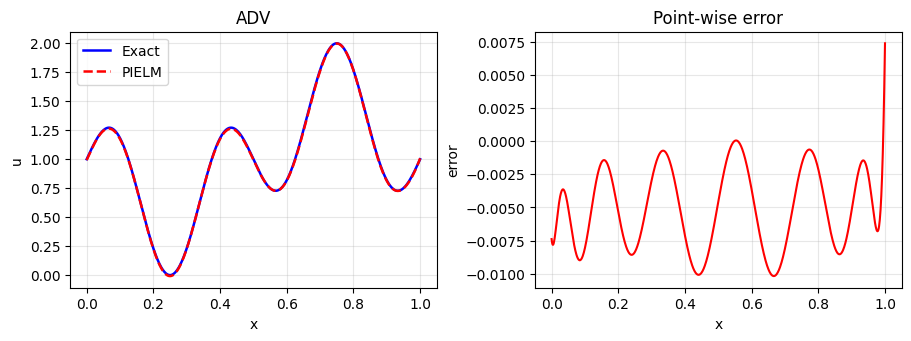

Running TC-2 (Diffusion)…


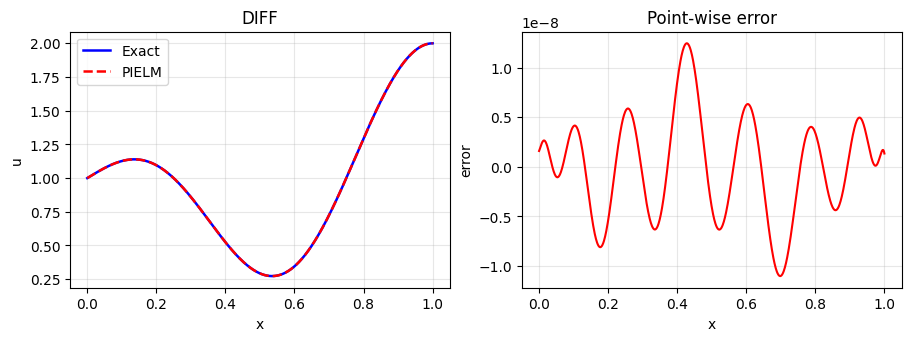

Running TC-3 (Adv–Diff, nu<0)…


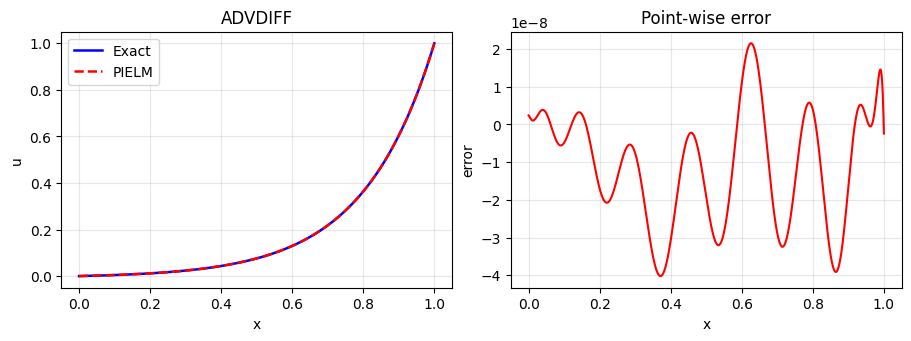

Running TC-4 (1D unsteady advection)…


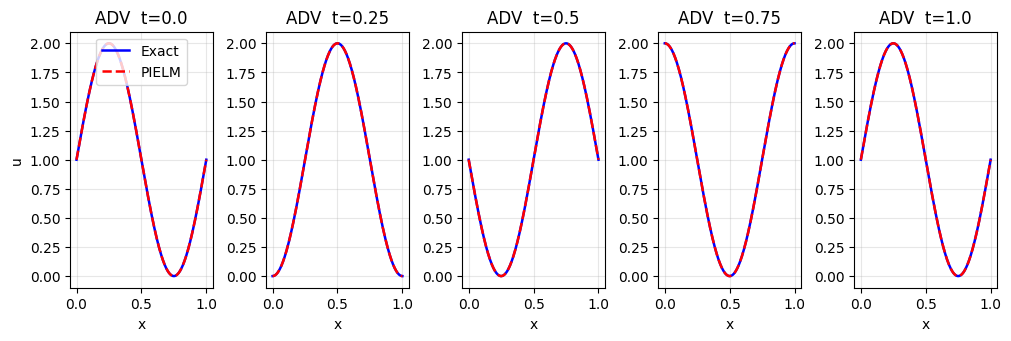

Running TC-5 (1D unsteady diffusion, nu<0)…


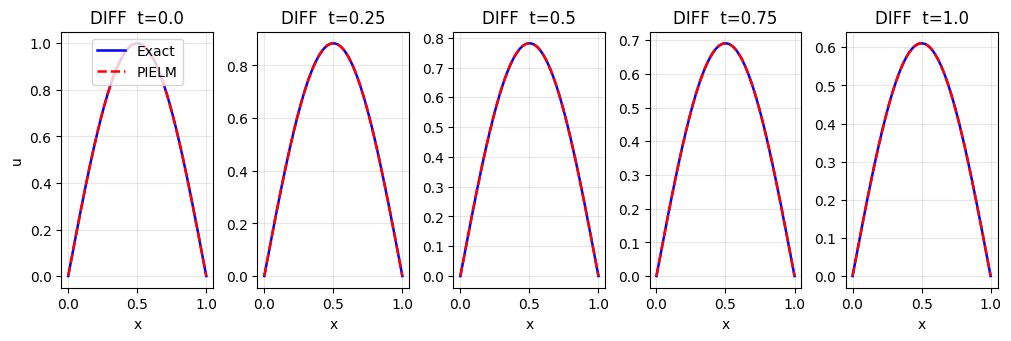

Running TC-6 (1D unsteady adv–diff, nu<0)…


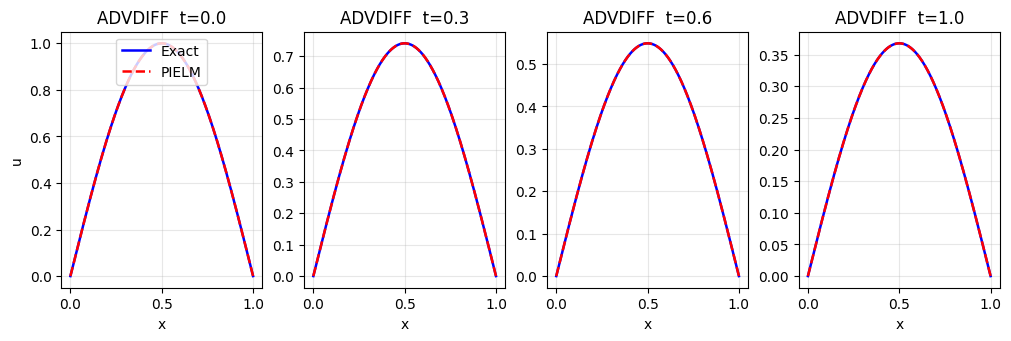

Running TC-7 (2D steady Poisson)…


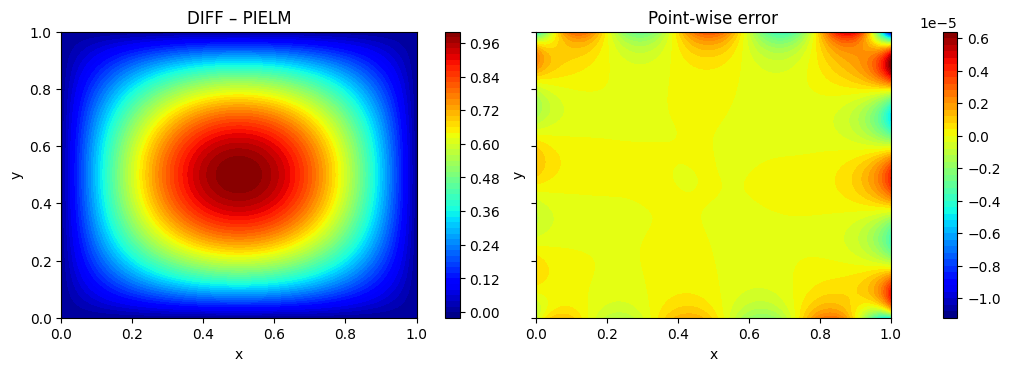

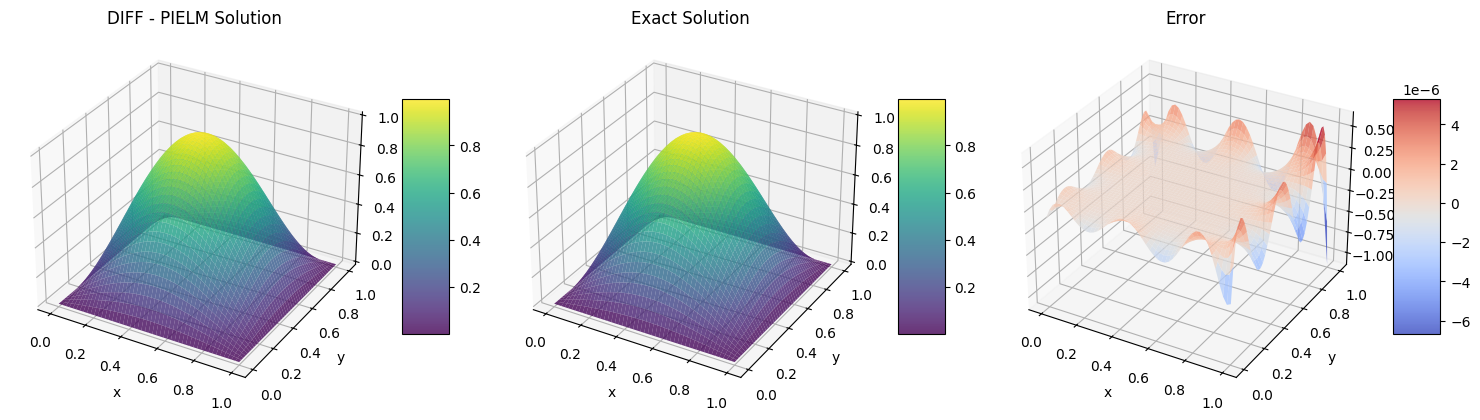

Running TC-8 (2D steady adv–diff)…


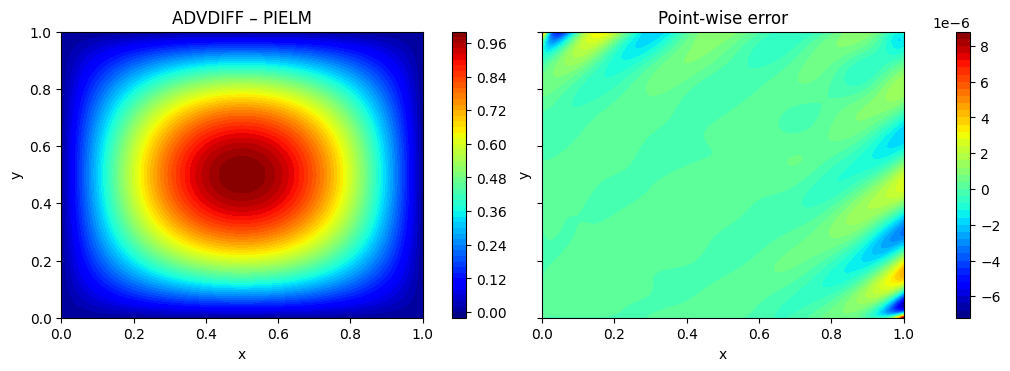

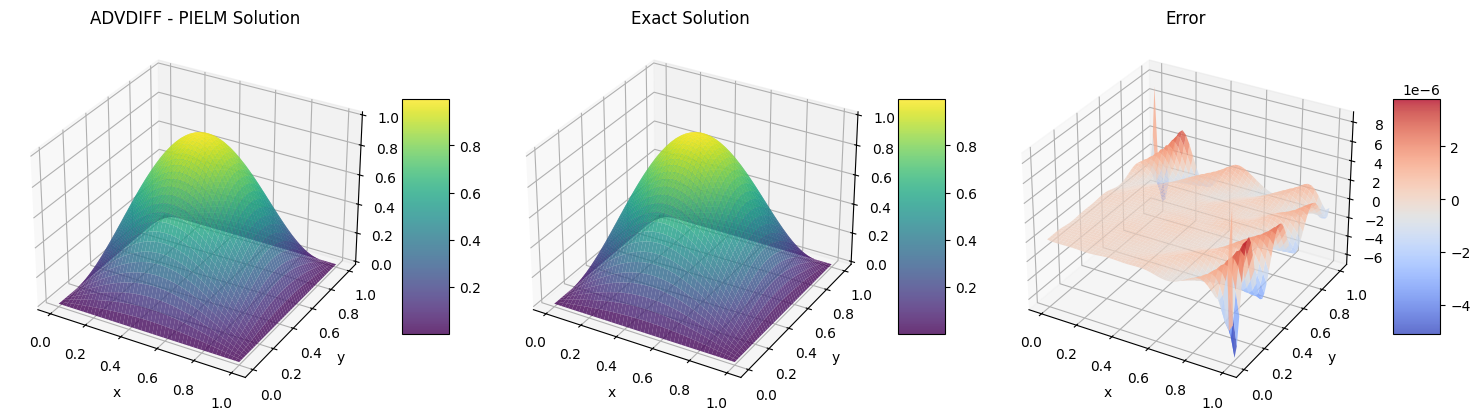

Running TC-9 (2D unsteady adv–diff, nu<0)…


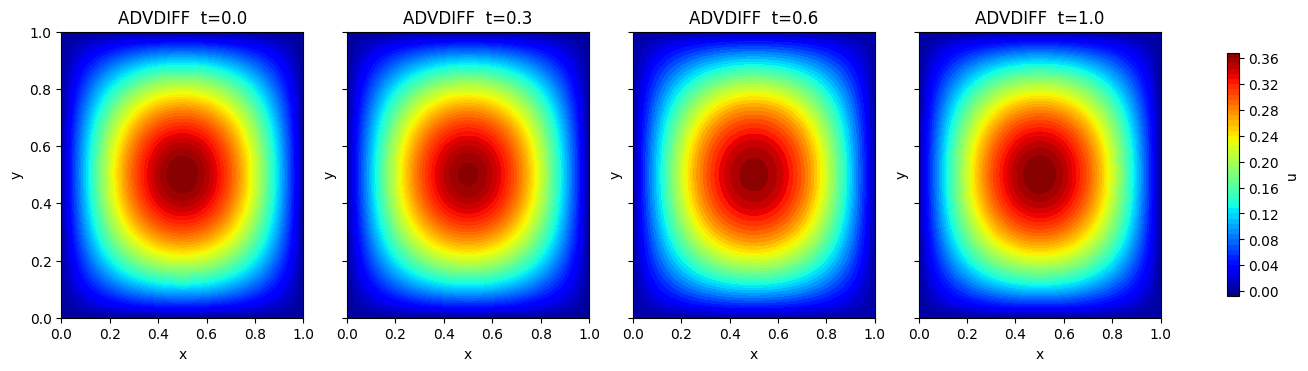

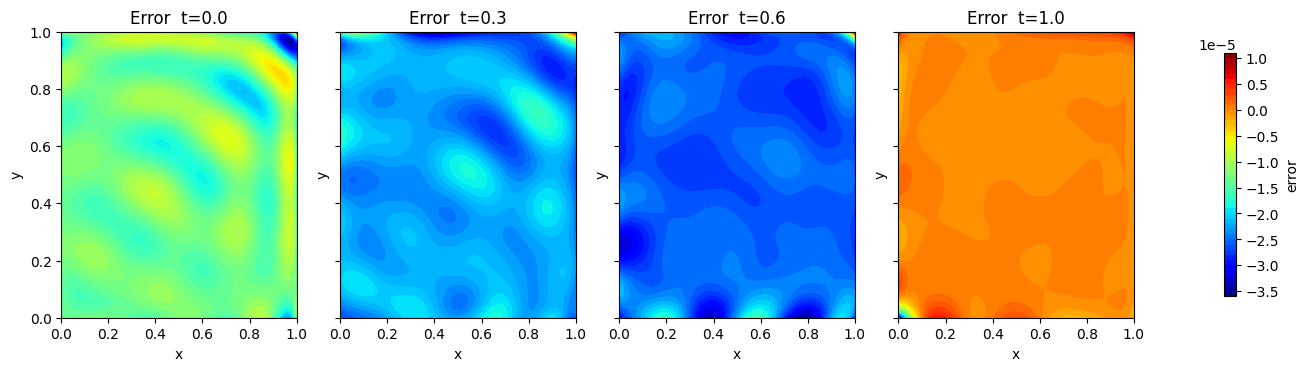

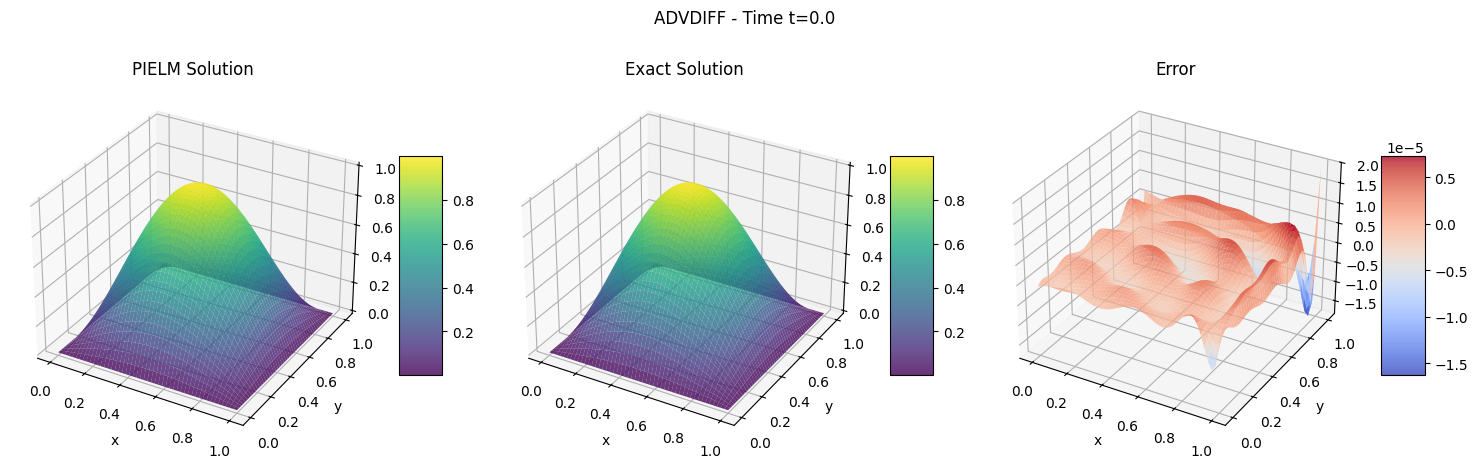

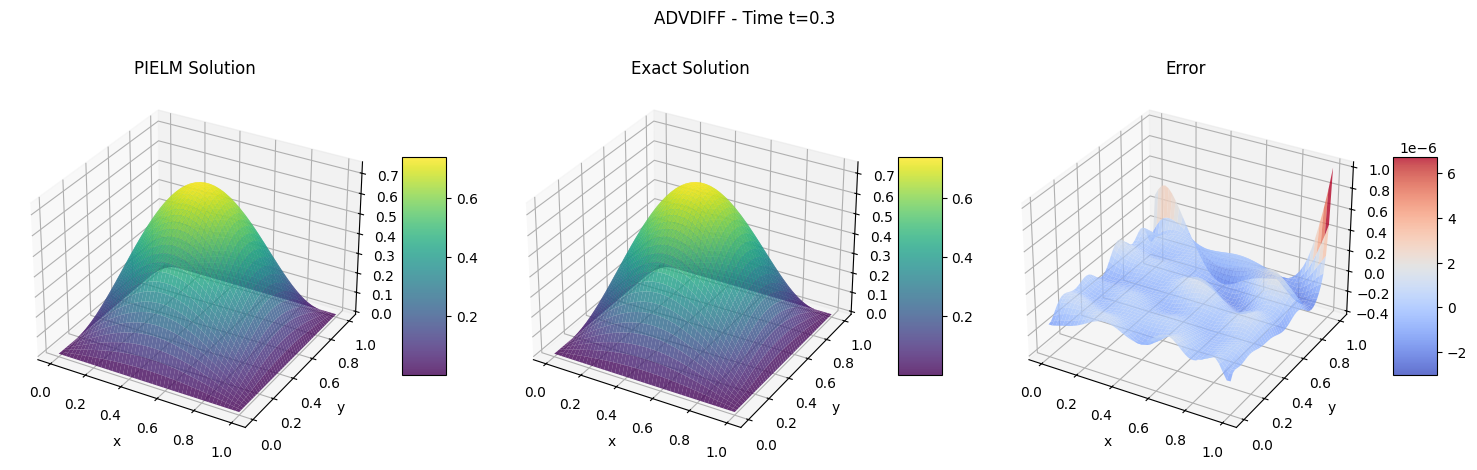

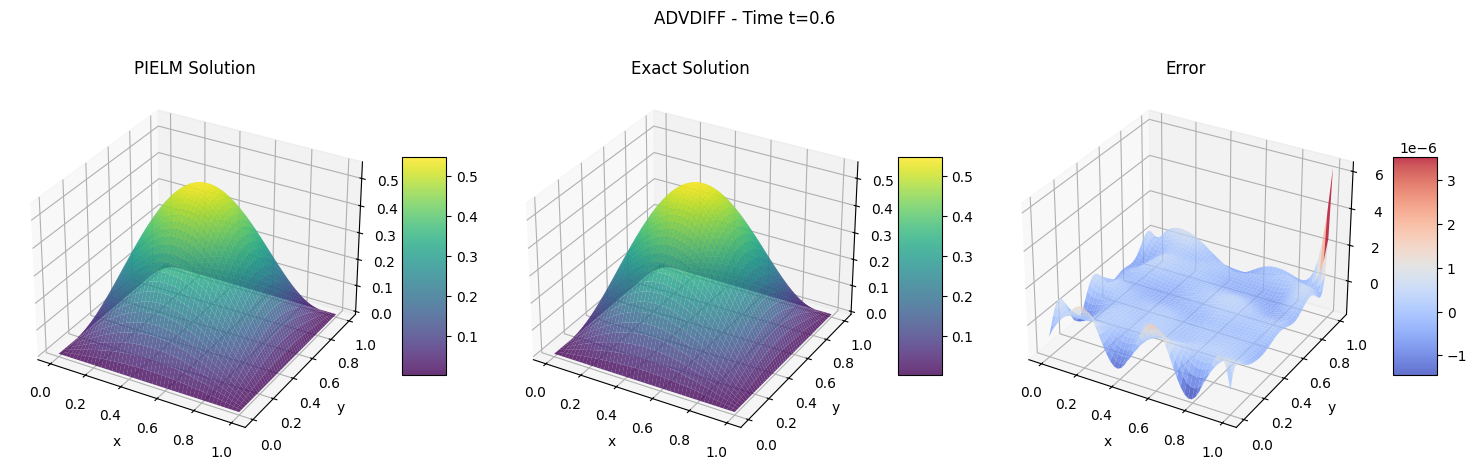

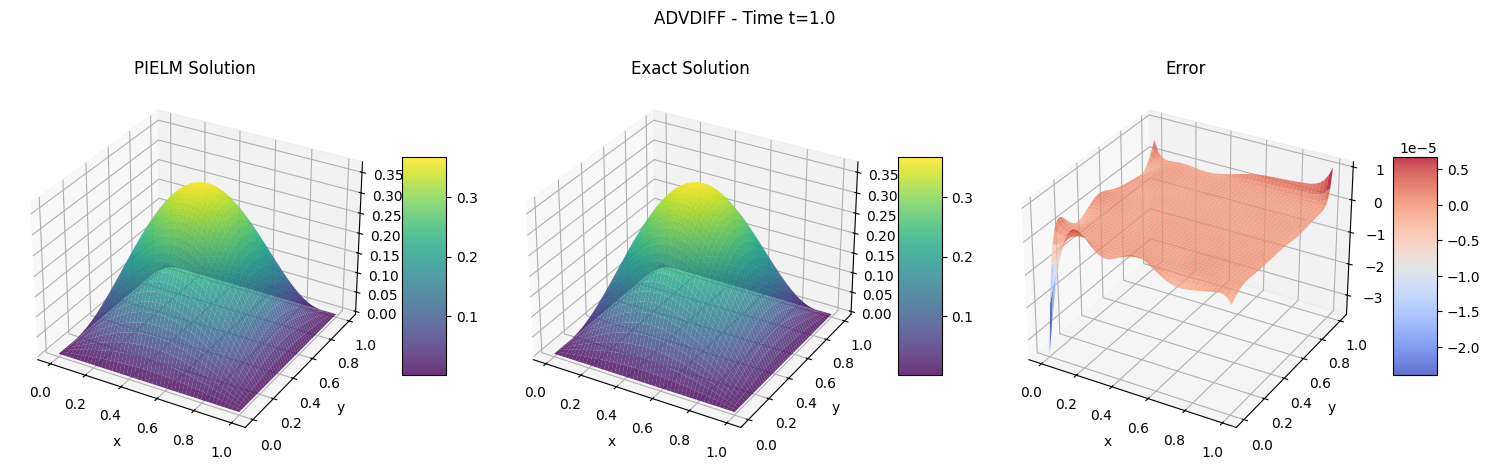

In [13]:
# =============================================================
# -------------------------- TEST CASES ------------------------
# All diffusion terms now use +nu in rows.
# If the physical PDE expects a minus Laplacian, pass a NEGATIVE nu.
# =============================================================

# TC-1 1D steady advection: u_x = R(x)
def run_TC1():
    u_exact = lambda x: np.sin(2*pi*x) * np.cos(4*pi*x) + 1.0
    R = lambda x: 2*pi*np.cos(2*pi*x)*np.cos(4*pi*x) - 4*pi*np.sin(2*pi*x)*np.sin(4*pi*x)
    xL, xR = 0.0, 1.0
    gL = float(u_exact(np.array([[xL]])).item())
    gR = float(u_exact(np.array([[xR]])).item())
    problem = {
        'dim': 1, 'time': False,
        'operator': {'type': 'adv'},
        'coeffs': {'a': 1.0},
        'forcing': R,
        'domain': {'type':'interval','x':(xL,xR)},
        'bc': {'type':'dirichlet','gL': gL, 'gR': gR},
        'collocation': {'N_f': 120, 'N_bc': 2},
        'model': {'N_star': 122, 'seed': 1},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 900}
    }
    return solve_pielm(problem)

# TC-2 1D steady diffusion/Poisson: u_xx = R(x)
def run_TC2():
    u_exact = lambda x: np.sin(0.5*pi*x) * np.cos(2*pi*x) + 1.0
    R = lambda x: - (17.0/4.0)*(pi**2)*np.sin(0.5*pi*x)*np.cos(2*pi*x) \
                   - 2.0*(pi**2)*np.cos(0.5*pi*x)*np.sin(2*pi*x)
    xL, xR = 0.0, 1.0
    gL = float(u_exact(np.array([[xL]])).item())
    gR = float(u_exact(np.array([[xR]])).item())
    problem = {
        'dim': 1, 'time': False,
        'operator': {'type': 'diff'},  # 'poisson' also OK
        'coeffs': {},  # nu ignored here
        'forcing': R,
        'domain': {'type':'interval','x':(xL,xR)},
        'bc': {'type':'dirichlet','gL': gL, 'gR': gR},
        'collocation': {'N_f': 140, 'N_bc': 2},
        'model': {'N_star': 142, 'seed': 2},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 900}
    }
    return solve_pielm(problem)

# TC-3 1D steady advection–diffusion: a u_x + nu u_xx = 0
def run_TC3(nu= -0.20):  # set NEGATIVE to reproduce a u_x − |nu| u_xx = 0
    u_exact = lambda x: (np.exp(x/(-nu)) - 1.0) / (np.exp(1.0/(-nu)) - 1.0)
    R = lambda x: np.zeros_like(x)
    xL, xR = 0.0, 1.0
    gL, gR = 0.0, 1.0
    problem = {
        'dim': 1, 'time': False,
        'operator': {'type': 'advdiff'},
        'coeffs': {'a': 1.0, 'nu': float(nu)},
        'forcing': R,
        'domain': {'type':'interval','x':(xL,xR)},
        'bc': {'type':'dirichlet','gL': gL, 'gR': gR},
        'collocation': {'N_f': 120, 'N_bc': 2},
        'model': {'N_star': 122, 'seed': 3},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 900}
    }
    return solve_pielm(problem)

# TC-4 1D unsteady advection (periodic): u_t + a u_x = 0 (nu=0)
def run_TC4():
    a = 1.0
    u_exact = lambda x, t: 1.0 + np.sin(2*np.pi*(x - t))
    forcing  = lambda x, t: np.zeros_like(x)
    xL, xR = 0.0, 1.0
    problem = {
        'dim': 1, 'time': True,
        'operator': {'type': 'adv'},
        'coeffs': {'a': a, 'nu': 0.0},
        'forcing': forcing,
        'domain': {'type':'interval','x':(xL,xR)},
        'bc': {'type':'periodic'},
        'ic': {'F': lambda x: u_exact(x, 0.0)},
        'tmax': 1.0,
        'collocation': {'N_f': 1200, 'N_bc': 200, 'N_ic': 180},
        'model': {'N_star': 1600, 'seed': 7, 'ridge': 1e-8},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 900, 'times': [0.0, 0.25, 0.5, 0.75, 1.0]}
    }
    return solve_pielm(problem)

# TC-5 1D unsteady diffusion: u_t + nu u_xx = 0  (set nu NEGATIVE)
def run_TC5():
    nu = -0.05  # negative to represent u_t - 0.05 u_xx = 0
    u_exact = lambda x, t: np.sin(np.pi*x) * np.exp(-(abs(nu))*(np.pi**2)*t)
    forcing  = lambda x, t: np.zeros_like(x)
    xL, xR = 0.0, 1.0
    problem = {
        'dim': 1, 'time': True,
        'operator': {'type': 'diff'},
        'coeffs': {'a': 0.0, 'nu': nu},
        'forcing': forcing,
        'domain': {'type':'interval','x':(xL,xR)},
        'bc': {'type':'dirichlet', 'gL': 0.0, 'gR': 0.0},
        'ic': {'F': lambda x: u_exact(x, 0.0)},
        'tmax': 1.0,
        'collocation': {'N_f': 1200, 'N_bc': 120, 'N_ic': 120},
        'model': {'N_star': 1600, 'seed': 8, 'ridge': 1e-8},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 900, 'times': [0.0, 0.25, 0.5, 0.75, 1.0]}
    }
    return solve_pielm(problem)

# TC-6 1D unsteady advection–diffusion: u_t + a u_x + nu u_xx = R; use nu NEGATIVE
def run_TC6():
    a, nu = 0.7, -0.02
    def u_exact(x, t):
        return np.sin(np.pi*x) * np.exp(-t)
    def forcing(x, t):
        ut  = -np.sin(np.pi*x) * np.exp(-t)
        ux  =  np.pi*np.cos(np.pi*x) * np.exp(-t)
        uxx = - (np.pi**2) * np.sin(np.pi*x) * np.exp(-t)
        return ut + a*ux + nu*uxx    # +nu form (nu is negative)
    xL, xR = 0.0, 1.0
    problem = {
        'dim': 1, 'time': True,
        'operator': {'type': 'advdiff'},
        'coeffs': {'a': a, 'nu': nu},
        'forcing': forcing,
        'domain': {'type':'interval','x':(xL,xR)},
        'bc': {'type':'dirichlet', 'gL': 0.0, 'gR': 0.0},
        'ic': {'F': lambda x: u_exact(x, 0.0)},
        'tmax': 1.0,
        'collocation': {'N_f': 1400, 'N_bc': 120, 'N_ic': 160},
        'model': {'N_star': 1800, 'seed': 4, 'ridge': 1e-8},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 900, 'times': [0.0, 0.3, 0.6, 1.0]}
    }
    return solve_pielm(problem)

# TC-7 2D steady Poisson/diffusion on unit square: a=b=0, nu=+1
def run_TC7():
    def u_exact(x, y):
        return np.sin(np.pi*x) * np.sin(np.pi*y)
    def forcing(x, y):  # u_xx + u_yy = -2π^2 u
        return -2*(np.pi**2) * np.sin(np.pi*x) * np.sin(np.pi*y)
    problem = {
        'dim': 2, 'time': False,
        'operator': {'type': 'diff'},
        'coeffs': {'a': 0.0, 'b': 0.0, 'nu': 1.0},  # +nu
        'forcing': forcing,
        'domain': {'type':'rect','x':(0.0,1.0),'y':(0.0,1.0)},
        'bc': {'type': 'dirichlet', 'g': lambda x,y: 0.0},
        'collocation': {'N_f': 2500, 'N_bc': 400},
        'model': {'N_star': 3200, 'seed': 3, 'ridge': 1e-8},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 140, 'surface3d': True}
    }
    return solve_pielm(problem)

# TC-8 2D steady advection–diffusion: +nu form
def run_TC8():
    a, b, nu = 1.0, 1.0, 0.01
    def u_exact(x, y):
        return np.sin(np.pi*x) * np.sin(np.pi*y)
    def forcing(x, y):
        ux  = np.pi*np.cos(np.pi*x) * np.sin(np.pi*y)
        uy  = np.pi*np.sin(np.pi*x) * np.cos(np.pi*y)
        uxx = - (np.pi**2) * np.sin(np.pi*x) * np.sin(np.pi*y)
        uyy = - (np.pi**2) * np.sin(np.pi*x) * np.sin(np.pi*y)
        return a*ux + b*uy + nu*(uxx + uyy)   # +nu form
    problem = {
        'dim': 2, 'time': False,
        'operator': {'type': 'advdiff'},
        'coeffs': {'a': a, 'b': b, 'nu': nu},
        'forcing': forcing,
        'domain': {'type':'rect','x':(0.0,1.0),'y':(0.0,1.0)},
        'bc': {'type': 'dirichlet', 'g': u_exact},
        'collocation': {'N_f': 2500, 'N_bc': 400},
        'model': {'N_star': 3400, 'seed': 5, 'ridge': 1e-8},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 140, 'surface3d': True}
    }
    return solve_pielm(problem)

# TC-9 2D unsteady adv-diff: u_t + a u_x + b u_y + nu Δu = R  (nu NEGATIVE)
def run_TC9():
    a, b, nu = 0.5, 0.3, -0.01
    def u_xy(x, y): return np.sin(np.pi*x) * np.sin(np.pi*y)
    def u_exact(x, y, t): return u_xy(x, y) * np.exp(-t)
    def forcing(x, y, t):
        ut  = -u_xy(x,y) * np.exp(-t)
        ux  =  np.pi*np.cos(np.pi*x) * np.sin(np.pi*y) * np.exp(-t)
        uy  =  np.pi*np.sin(np.pi*x) * np.cos(np.pi*y) * np.exp(-t)
        uxx = - (np.pi**2) * u_xy(x,y) * np.exp(-t)
        uyy = - (np.pi**2) * u_xy(x,y) * np.exp(-t)
        return ut + a*ux + b*uy + nu*(uxx + uyy)  # +nu form; nu negative
    plot_times = [0.0, 0.3, 0.6, 1.0]
    problem = {
        'dim': 2, 'time': True,
        'operator': {'type': 'advdiff'},
        'coeffs': {'a': a, 'b': b, 'nu': nu},
        'forcing': forcing,
        'domain': {'type':'rect','x':(0.0,1.0),'y':(0.0,1.0)},
        'bc': {'type': 'dirichlet', 'g': lambda x,y,t: u_exact(x,y,t)},
        'ic': {'F': lambda x,y: u_exact(x,y,0.0)},
        'tmax': 1.0,
        'collocation': {'N_f': 6000, 'N_bc': 600, 'N_ic': 600},
        'model': {'N_star': 7000, 'seed': 11, 'ridge': 1e-8},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 120, 'times': plot_times, 'surface3d': True}
    }
    return solve_pielm(problem)

# ---------------- convenience main ----------------
if __name__ == "__main__":
    print("Running TC-1 (Advection)…"); run_TC1()
    print("Running TC-2 (Diffusion)…"); run_TC2()
    print("Running TC-3 (Adv–Diff, nu<0)…"); run_TC3()
    print("Running TC-4 (1D unsteady advection)…"); run_TC4()
    print("Running TC-5 (1D unsteady diffusion, nu<0)…"); run_TC5()
    print("Running TC-6 (1D unsteady adv–diff, nu<0)…"); run_TC6()
    print("Running TC-7 (2D steady Poisson)…"); run_TC7()
    print("Running TC-8 (2D steady adv–diff)…"); run_TC8()
    print("Running TC-9 (2D unsteady adv–diff, nu<0)…"); run_TC9()


Running RAN-1 (1D steady adv-diff, variable a(x), nu<0 for -Δ) …


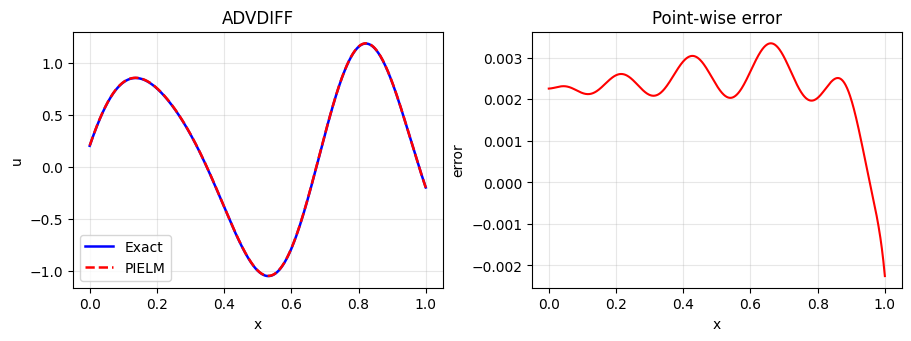

[Eval 1D steady] rel-L2 = 3.317e-03

Running RAN-2 (1D unsteady advection, periodic) …


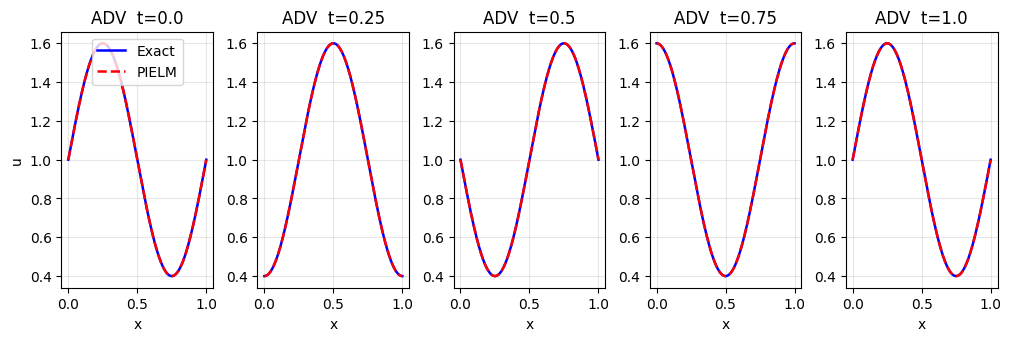

[Eval 1D unsteady @ t=0.00] rel-L2 = 1.275e-05
[Eval 1D unsteady @ t=0.25] rel-L2 = 1.196e-05
[Eval 1D unsteady @ t=0.50] rel-L2 = 1.392e-05
[Eval 1D unsteady @ t=0.75] rel-L2 = 2.088e-05
[Eval 1D unsteady @ t=1.00] rel-L2 = 2.555e-05
[Eval 1D unsteady] max rel-L2 over times = 2.555e-05

Running RAN-3 (2D steady adv-diff, +nu) …


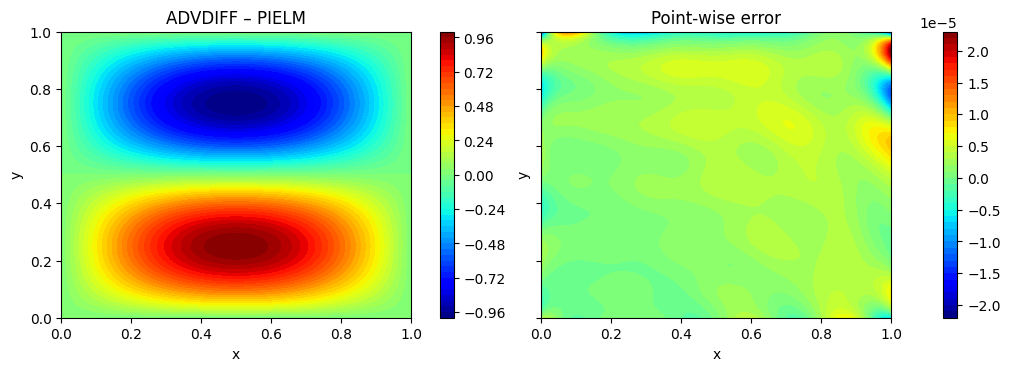

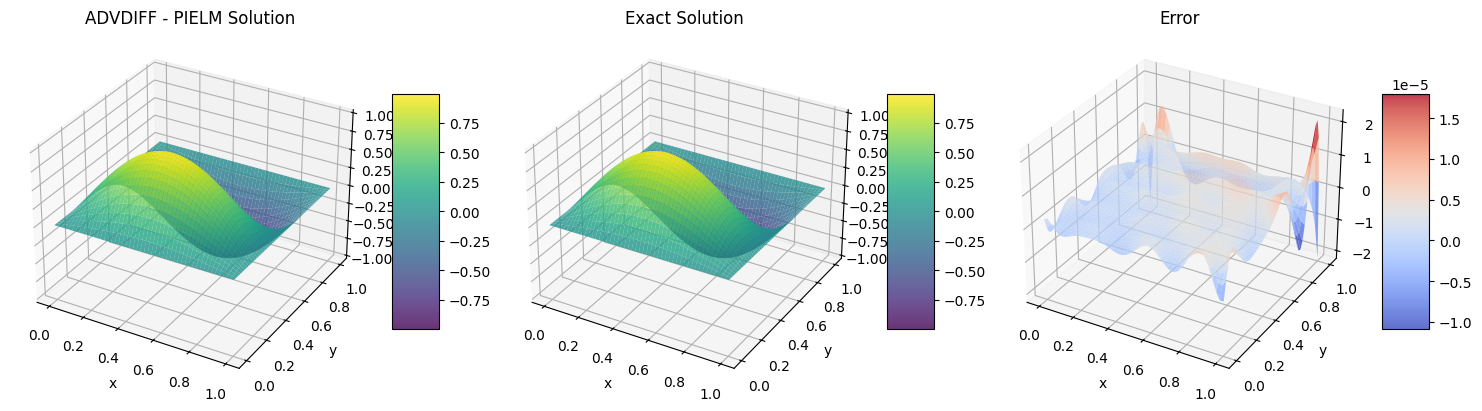

[Eval 2D steady] rel-L2 = 6.177e-06

Running RAN-4 (2D unsteady adv-diff, variable a,b, nu<0 for -Δ) …


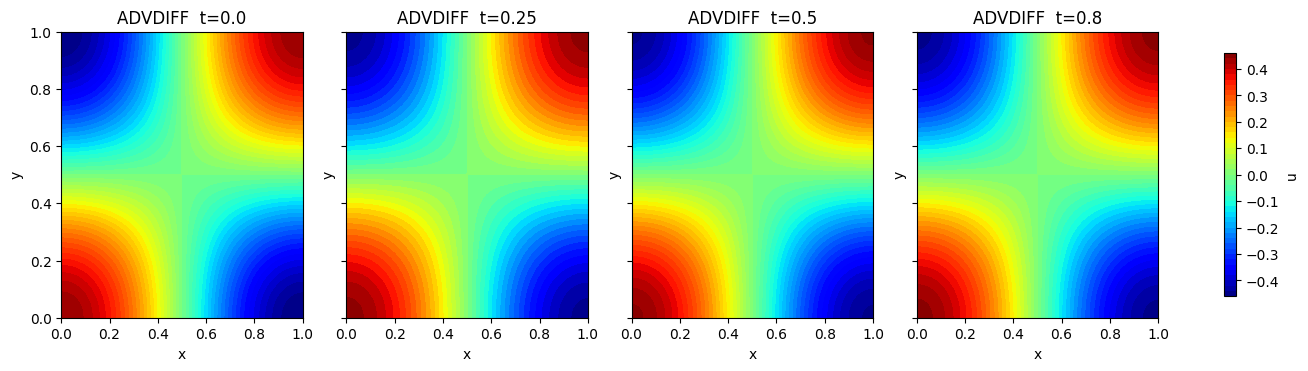

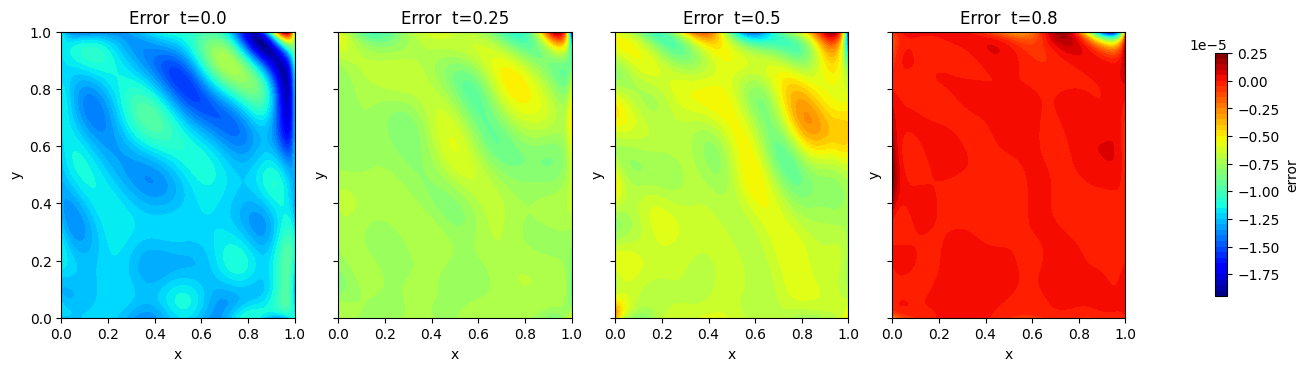

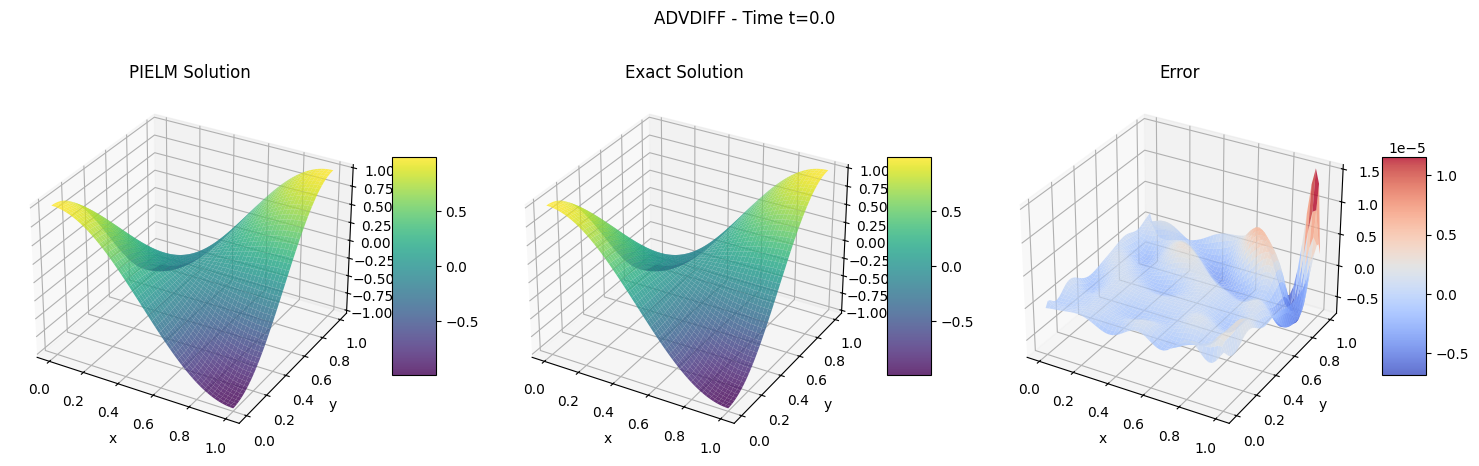

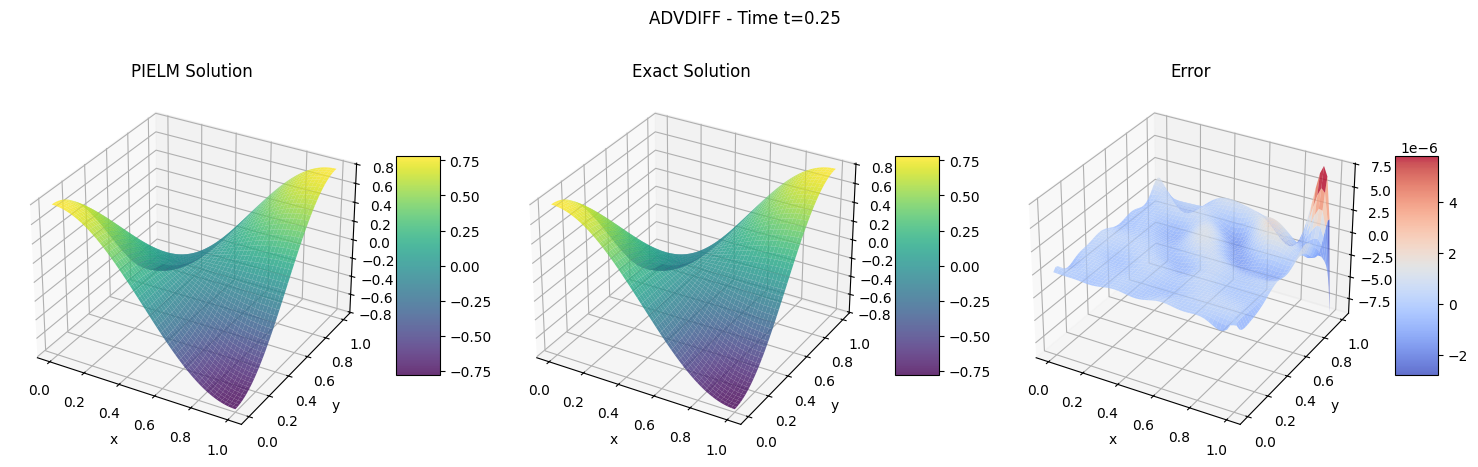

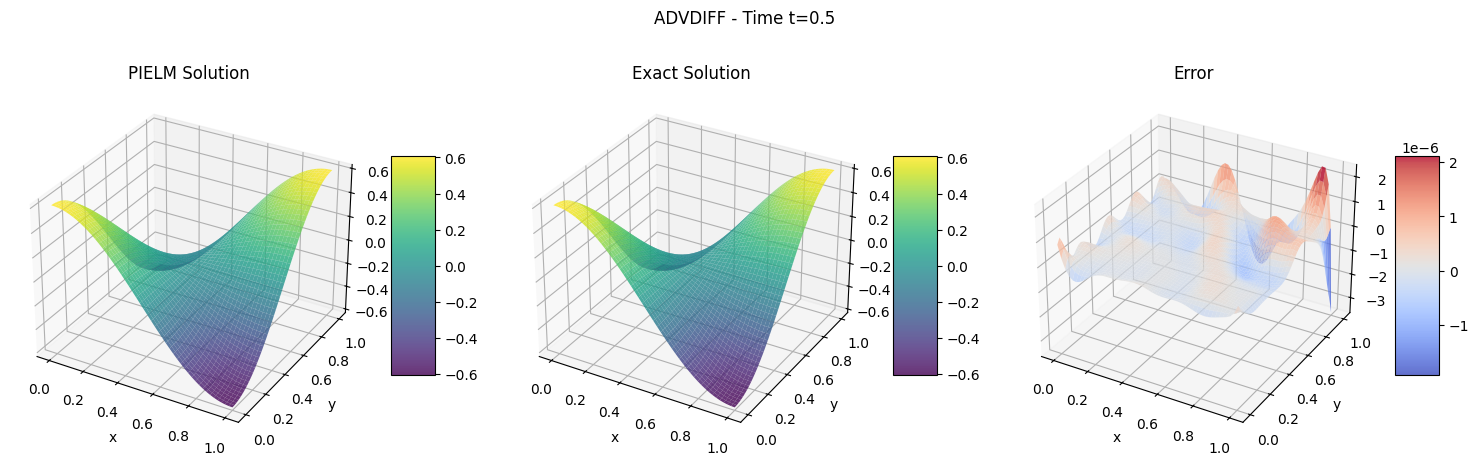

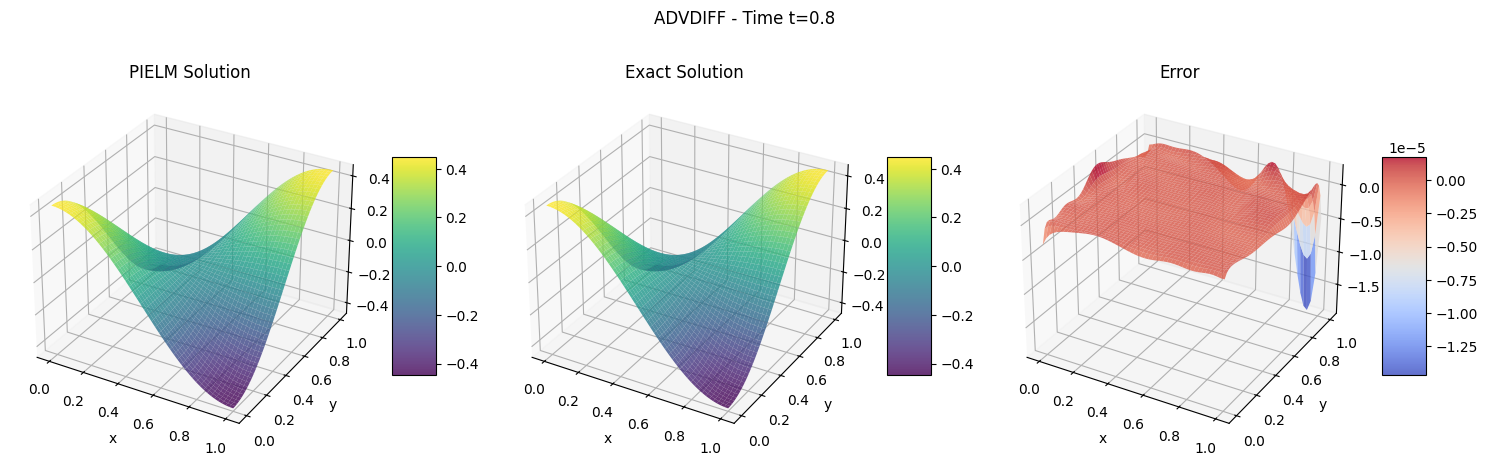

[Eval 2D unsteady @ t=0.00] rel-L2 = 3.360e-06
[Eval 2D unsteady @ t=0.25] rel-L2 = 1.644e-06
[Eval 2D unsteady @ t=0.50] rel-L2 = 1.181e-06
[Eval 2D unsteady @ t=0.80] rel-L2 = 4.323e-06
[Eval 2D unsteady] max rel-L2 over times = 4.323e-06


In [14]:
# =============================================================
# Extra: 4 "random" (seeded) configs with known exact solutions
# (All cases normalized to +nu; use negative nu to represent -Δu)
# =============================================================

rng_py = np.random.default_rng(123)

# ---------- tiny evaluation helpers ----------
def _rel_l2(a, b):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    num = np.linalg.norm(a - b)
    den = max(1e-14, np.linalg.norm(b))
    return float(num / den)

def eval_1d_steady(u_pred, u_exact, xL=0.0, xR=1.0, n=4000):
    xs = np.linspace(xL, xR, n).reshape(-1,1)
    up = u_pred(xs)
    ue = u_exact(xs)
    rel = _rel_l2(up, ue)
    print(f"[Eval 1D steady] rel-L2 = {rel:.3e}")
    return rel

def eval_1d_time(u_pred, u_exact, xL=0.0, xR=1.0, times=(0.0,0.25,0.5,0.75,1.0), n=2000):
    xs = np.linspace(xL, xR, n).reshape(-1,1)
    errs = []
    for t in times:
        tt = np.full_like(xs, t)
        up = u_pred(xs, tt)
        ue = u_exact(xs, tt)
        errs.append(_rel_l2(up, ue))
    for t,e in zip(times, errs):
        print(f"[Eval 1D unsteady @ t={t:.2f}] rel-L2 = {e:.3e}")
    print(f"[Eval 1D unsteady] max rel-L2 over times = {max(errs):.3e}")
    return errs

def eval_2d_rect_steady(u_pred, u_exact, xL=0.0, xR=1.0, yL=0.0, yR=1.0, n=120):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    P = np.c_[xx.ravel(), yy.ravel()]
    up = u_pred(P).reshape(n,n)
    ue = u_exact(xx, yy)
    rel = _rel_l2(up, ue)
    print(f"[Eval 2D steady] rel-L2 = {rel:.3e}")
    return rel

def eval_2d_rect_time(u_pred, u_exact, xL=0.0, xR=1.0, yL=0.0, yR=1.0, times=(0.0,0.3,0.6,1.0), n=80):
    xs, ys = np.linspace(xL,xR,n), np.linspace(yL,yR,n)
    xx, yy = np.meshgrid(xs, ys)
    errs = []
    for t in times:
        P = np.c_[xx.ravel(), yy.ravel(), np.full((n*n,1), t)]
        up = u_pred(P).reshape(n,n)
        ue = u_exact(xx, yy, t)
        errs.append(_rel_l2(up, ue))
    for t,e in zip(times, errs):
        print(f"[Eval 2D unsteady @ t={t:.2f}] rel-L2 = {e:.3e}")
    print(f"[Eval 2D unsteady] max rel-L2 over times = {max(errs):.3e}")
    return errs

# -------------------------------------------------------------
# RAN-1: 1D steady advection-diffusion with variable a(x)
# Normalized PDE:  a(x) * u_x + nu * u_xx = R(x)
# (Choose nu < 0 here to reproduce a(x) * u_x - |nu| * u_xx)
# -------------------------------------------------------------
def run_RAN1():
    xL, xR = 0.0, 1.0
    nu = -0.10  # negative nu encodes the classical "minus diffusion"
    u_exact = lambda x: np.sin(3*np.pi*x) + 0.2*np.cos(5*np.pi*x)
    ux  = lambda x: 3*np.pi*np.cos(3*np.pi*x) - np.pi*np.sin(5*np.pi*x)
    uxx = lambda x: -9*(np.pi**2)*np.sin(3*np.pi*x) - 5*(np.pi**2)*np.cos(5*np.pi*x)
    a_fun = lambda x: 1.0 + 0.5*x
    R = lambda x: a_fun(x)*ux(x) + nu*uxx(x)  # +nu form

    gL = float(u_exact(np.array([[xL]])).item())
    gR = float(u_exact(np.array([[xR]])).item())
    N_f, N_bc = 180, 60
    problem = {
        'dim': 1,
        'time': False,
        'operator': {'type':'advdiff'},
        'coeffs': {'a': a_fun, 'nu': nu},
        'forcing': R,
        'domain': {'type':'interval','x':(xL,xR)},
        'bc': {'type':'dirichlet','gL': gL, 'gR': gR},
        'collocation': {'N_f': N_f, 'N_bc': N_bc},
        'model': {'N_star': N_f + N_bc, 'seed': 101, 'ridge': 1e-8},
        'weights': {'pde': 1.0, 'bc': 1.0},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 900}
    }
    u_pred, info = solve_pielm(problem)
    eval_1d_steady(u_pred, u_exact, xL, xR)
    return u_pred, info

# -------------------------------------------------------------
# RAN-2: 1D unsteady advection (periodic), R = 0
# PDE: u_t + a u_x = 0  (nu = 0)
# -------------------------------------------------------------
def run_RAN2():
    a = 1.0
    u_exact = lambda x,t: 1.0 + 0.6*np.sin(2*np.pi*(x - t))
    forcing = lambda x,t: np.zeros_like(x)

    xL, xR = 0.0, 1.0
    N_f, N_bc, N_ic = 1500, 240, 220
    problem = {
        'dim': 1,
        'time': True,
        'operator': {'type':'adv'},
        'coeffs': {'a': a, 'nu': 0.0},
        'forcing': forcing,
        'domain': {'type':'interval','x':(xL,xR)},
        'bc': {'type':'periodic'},
        'ic': {'F': lambda x: u_exact(x, 0.0)},
        'tmax': 1.0,
        'collocation': {'N_f': N_f, 'N_bc': N_bc, 'N_ic': N_ic},
        'model': {'N_star': N_f + N_bc + N_ic, 'seed': 202, 'ridge': 1e-8},
        'weights': {'pde': 1.0, 'bc': 5.0, 'ic': 1.0},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 900, 'times': [0.0, 0.25, 0.5, 0.75, 1.0]}
    }
    u_pred, info = solve_pielm(problem)
    eval_1d_time(u_pred, u_exact, xL, xR, times=[0.0,0.25,0.5,0.75,1.0])
    return u_pred, info

# -------------------------------------------------------------
# RAN-3: 2D steady advection-diffusion on the unit square
# Normalized PDE:  a u_x + b u_y + nu (u_xx + u_yy) = R(x,y)  (nu > 0)
# -------------------------------------------------------------
def run_RAN3():
    a, b, nu_val = 0.3, -0.5, 0.02
    def u_exact(x,y):
        return np.sin(np.pi*x)*np.sin(2*np.pi*y)
    def forcing(x,y):
        ux  =  np.pi*np.cos(np.pi*x)*np.sin(2*np.pi*y)
        uy  =  2*np.pi*np.sin(np.pi*x)*np.cos(2*np.pi*y)
        uxx = - (np.pi**2)*np.sin(np.pi*x)*np.sin(2*np.pi*y)
        uyy = - (2*np.pi)**2*np.sin(np.pi*x)*np.sin(2*np.pi*y)
        return a*ux + b*uy + nu_val*(uxx + uyy)  # +nu form

    xL,xR,yL,yR = 0.0,1.0,0.0,1.0
    N_f, N_bc = 3000, 420
    problem = {
        'dim': 2,
        'time': False,
        'operator': {'type':'advdiff'},
        'coeffs': {'a': a, 'b': b, 'nu': nu_val},
        'forcing': forcing,
        'domain': {'type':'rect','x':(xL,xR),'y':(yL,yR)},
        'bc': {'type':'dirichlet','g': u_exact},
        'collocation': {'N_f': N_f, 'N_bc': N_bc},
        'model': {'N_star': N_f + N_bc, 'seed': 303, 'ridge': 1e-8},
        'weights': {'pde': 1.0, 'bc': 3.0},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 140, 'surface3d': True}
    }
    u_pred, info = solve_pielm(problem)
    eval_2d_rect_steady(u_pred, u_exact, xL,xR,yL,yR, n=120)
    return u_pred, info

# -------------------------------------------------------------
# RAN-4: 2D unsteady adv-diff with variable a(x,y), b(x,y)
# Normalized PDE:  u_t + a u_x + b u_y + nu (u_xx + u_yy) = R
# (Use nu < 0 to reproduce the usual "minus diffusion")
# -------------------------------------------------------------
def run_RAN4():
    nu = -0.01  # negative encodes u_t + ... - |nu| Δu
    a_fun = lambda x,y: 0.4 + 0.2*np.sin(2*np.pi*x)
    b_fun = lambda x,y: -0.3 + 0.1*np.cos(2*np.pi*y)

    def u_exact(x,y,t):
        return np.cos(np.pi*x)*np.cos(np.pi*y)*np.exp(-t)

    def forcing(x,y,t):
        ut  = -np.cos(np.pi*x)*np.cos(np.pi*y)*np.exp(-t)
        ux  = -np.pi*np.sin(np.pi*x)*np.cos(np.pi*y)*np.exp(-t)
        uy  = -np.pi*np.cos(np.pi*x)*np.sin(np.pi*y)*np.exp(-t)
        uxx = - (np.pi**2)*np.cos(np.pi*x)*np.cos(np.pi*y)*np.exp(-t)
        uyy = - (np.pi**2)*np.cos(np.pi*x)*np.cos(np.pi*y)*np.exp(-t)
        return ut + a_fun(x,y)*ux + b_fun(x,y)*uy + nu*(uxx + uyy)  # +nu form

    times = [0.0, 0.25, 0.5, 0.8]
    xL,xR,yL,yR = 0.0,1.0,0.0,1.0
    N_f, N_bc, N_ic = 7000, 600, 600
    problem = {
        'dim': 2,
        'time': True,
        'operator': {'type': 'advdiff'},
        'coeffs': {'a': a_fun, 'b': b_fun, 'nu': nu},
        'forcing': forcing,
        'domain': {'type':'rect','x':(xL,xR),'y':(yL,yR)},
        'bc': {'type':'dirichlet','g': lambda x,y,t: u_exact(x,y,t)},
        'ic': {'F': lambda x,y: u_exact(x,y,0.0)},
        'tmax': max(times),
        'collocation': {'N_f': N_f, 'N_bc': N_bc, 'N_ic': N_ic},
        'model': {'N_star': N_f + N_bc + N_ic, 'seed': 404, 'ridge': 1e-8},
        'weights': {'pde': 1.0, 'bc': 2.0, 'ic': 1.0},
        'exact': u_exact,
        'plot': {'enabled': True, 'n_plot': 120, 'times': times, 'surface3d': True}
    }
    u_pred, info = solve_pielm(problem)
    eval_2d_rect_time(u_pred, u_exact, xL,xR,yL,yR, times=times, n=80)
    return u_pred, info

# ---------- run all four ----------
if __name__ == "__main__":
    print("\nRunning RAN-1 (1D steady adv-diff, variable a(x), nu<0 for -Δ) …")
    run_RAN1()
    print("\nRunning RAN-2 (1D unsteady advection, periodic) …")
    run_RAN2()
    print("\nRunning RAN-3 (2D steady adv-diff, +nu) …")
    run_RAN3()
    print("\nRunning RAN-4 (2D unsteady adv-diff, variable a,b, nu<0 for -Δ) …")
    run_RAN4()
